## Fuzzy дедубликатор

Проверка гипотизы применения алгоритмов нечеткого сравнения строкдля задачи поиска дубликатов

In [ ]:
# устанавливаем необходимые зависимости

!pip3 install deeppavlov==0.15.0
!pip3 install fuzzywuzzy==0.18.0
!pip3 install langdetect
!pip3 install razdel
!pip3 install sklearn==0.24.2
!pip3 install pathlib
!pip3 install sacremoses==0.0.35
!pip3 install numpy==1.21.6
!pip3 install pandas==0.25.3
!pip3 install matplotlib==3.1.2
!pip3 install transliterate==1.10.2

In [144]:
# получение списка импортированных модулей и их версий
!pip3 install session_info
import session_info
session_info.show()

In [214]:
import sys
# указываем где искать вспомогательные модули
sys.path.insert(0, '../src')

import re

from pathlib import Path

from fuzzywuzzy import process  ##
from fuzzywuzzy import fuzz

import numpy as np
import pandas as pd

from deeppavlov.models.tokenizers.nltk_moses_tokenizer import NLTKMosesTokenizer
from transliterate import translit, get_available_language_codes
from razdel import sentenize, tokenize
from langdetect import detect

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn. metrics import precision_recall_curve
from sklearn.metrics import classification_report,f1_score

from matplotlib import pyplot as plt

from gdrive_download import GDrive

In [148]:
# Инициализируем пути до данных
raw_fn = 'train.xlsx'
data_dir = Path.cwd().parent / 'data' / 'raw'

/home/ewp/DEV/itmo_dublicate_detection/data/raw/train.xlsx


In [199]:
# Скачиваем данные с гугл диска

link = 'https://docs.google.com/spreadsheets/d/1oD9Ow0cU4fnAcWdhREFsv-dsrXGggGuD/edit?usp=sharing&ouid=105579326681662213239&rtpof=true&sd=true'

gd = GDrive(link)
gd.download_file_from_google_drive(destination=data_dir / raw_fn)

Файл скачан: /home/ewp/DEV/itmo_dublicate_detection/data/raw/train.xlsx


In [6]:
# считываем выборку в датафрэм
df_raw = pd.read_excel(data_dir.joinpath(raw_fn), engine='openpyxl')[['name_1', 'name_2', 'is_duplicate']]

In [117]:
class FuzzyCompare:
    '''
    Методы обрадотки и сравнения строк
    '''

    def __init__(self):
        
        # инициализируем детокинайзер
        self.detokenizer = NLTKMosesTokenizer('en').detokenizer
        
    def norm_ref_items(self, txt):
        """
        Нормализация строки из датасета: приводим заники препинани к правильной структуре
        :param txt: исходная строка
        :return: преобразованная строка
        """
        if detect(txt) == 'ru':
            # производим транслитерацию на латиницу
            txt = translit(txt, language_code='ru', reversed=True)
        
        # расстановка пробелов и знаков препинания поправилам аббривеатур и разделителей
        tokens = self.detokenizer.detokenize([' '.join([_.text for _ in tokenize(txt)])])
        return ''.join(tokens).strip()
    
    def estimate(self, txt_1, txt_2, normalize=True):
        '''
        Подсчет меры близости двух строк
        :param txt_1: строка 1
        :param txt_2: строка 2
        :return: значение меры близости в пронтах
        '''
        if normalize:
            _txt_1 = self.norm_ref_items(txt_1)
            _txt_2 = self.norm_ref_items(txt_2)
        return process.extract(_txt_1, [_txt_2], scorer=fuzz.token_sort_ratio)[0][-1]
    
    def estimate_df(self, txt_tuple, normalize=True):
        '''
        Запуск сравнения для дадафрэйма: разбиваем значение по разделителю и производим сравнение
        '''
        t1, t2 = txt_tuple.split('|')
        return self.estimate(t1, t2)

In [204]:
# Инициализация класса и проверка работоспособности 
fz = FuzzyCompare()

fz.estimate('Romania'.lower(), 'RUMUNIA'.lower())

71

### Запуск оценки по всей выборке

In [ ]:
# удаляем дубликаты, если таковые имеются
df_raw = df_raw.drop_duplicates(subset=['name_1', 'name_2'], keep='first')

In [ ]:
%%time
# объединение в один столбец
df_raw = df_raw.assign(estimation = df_raw['name_1'] + '|' + df_raw['name_2'])
# расчет близости
df_raw['estimation'] = df_raw['estimation'].apply(fz.estimate_df)

# преобразование в условную вероятность для подсчета метрик
df_raw['estimation'] = df_raw['estimation'].apply(lambda x: x/100) 

### Построение ROC-кривой по результатам сравнения строк

LogisticRegression: ROC AUC=0.790


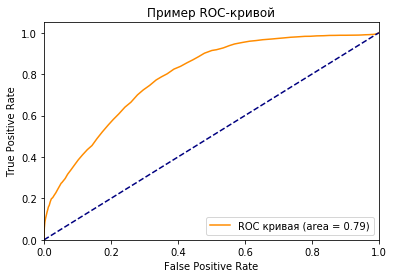

In [128]:
lr_probs = df_raw['estimation'].values
testy = df_raw['is_duplicate'].values

lr_auc = roc_auc_score(testy, lr_probs)
print('LogisticRegression: ROC AUC=%.3f' % (lr_auc))

# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(testy, lr_probs)
roc_auc = auc(fpr, tpr)

# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая Fuzzy')
plt.legend(loc="lower right")
plt.show()

### Построение PRC-кривой по результатам сравнения строк

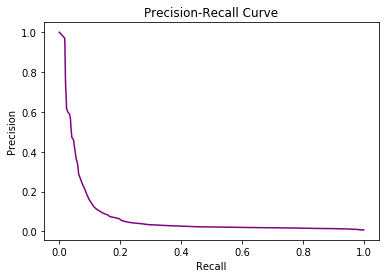

In [179]:
#строим precision-recall кривую
precision, recall, thresholds = precision_recall_curve(testy, lr_probs)

#отрисовываем precision-recall кривую
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()

In [255]:
lr_rate = [1 if l >=0.8 else 0for l in lr_probs]

In [256]:
print(classification_report(testy, lr_rate, output_dict=False))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    494161
           1       0.14      0.11      0.12      3658

    accuracy                           0.99    497819
   macro avg       0.57      0.55      0.56    497819
weighted avg       0.99      0.99      0.99    497819



In [235]:
report['macro avg']['f1-score']

0.5576189006384826

In [244]:
res = []
tr = []
for threshold in [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]:
    lr_rate = [1 if l >=threshold else 0 for l in lr_probs]
    tr.append(threshold)
    res.append(classification_report(testy, lr_rate, output_dict=True)['macro avg']['f1-score'])

In [248]:
res

[0.4361730577224466,
 0.46630562507998286,
 0.49265136293450235,
 0.5126271199481423,
 0.5314034483942205,
 0.5498006851285533,
 0.5576189006384826,
 0.5532688832568987,
 0.5405721559746264,
 0.5248188051995372]

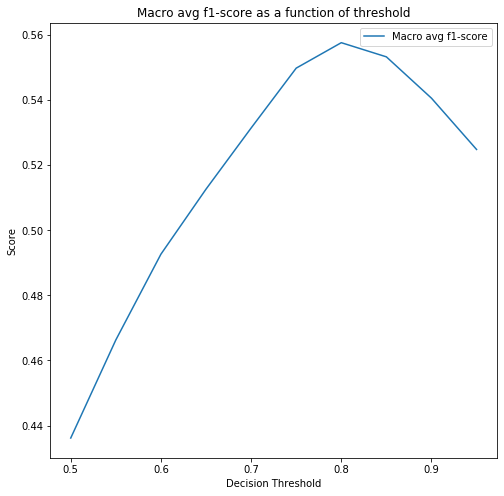

In [247]:
plt.figure(figsize=(8, 8))
plt.title("Macro avg f1-score as a function of threshold")
plt.plot(tr, res, label="Macro avg f1-score")
plt.ylabel("Score")
plt.xlabel("Decision Threshold")
plt.legend(loc='best')

### Выводы

Анализ показателей по порогу показывает, что при значении threshold=0.8 можно достичь 0.557 Macro avg f1-score